# How does Random Node Initialisation (RNI) affect aggregation in Graph Attention Networks (GATs)?

## Imports and Setup

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.12.0+cu116


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.12.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GATConv, GCNConv
from torch_geometric.datasets import PPI

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import pickle
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng()

## Models

In [4]:
class RandomNodeInitialiser(nn.Module):
    """Cats `num_rand_features` random features to the input features."""

    def __init__(self, num_rand_features):
        super().__init__()
        self.num_rand_features = num_rand_features

    def forward(self, x):
        if self.num_rand_features > 0:
            rand = torch.rand(( x.shape[0], self.num_rand_features)).to(device)
            x = torch.cat([x, rand], dim=1).to(device)
        return x

    def extra_repr(self):
        return f"{self.num_rand_features}"

In [5]:
class rGAT(torch.nn.Module):
    def __init__(self, random_features=0):
        super().__init__()
        
        self.rni = RandomNodeInitialiser(random_features)
        
        self.conv1 = GATConv(train_dataset.num_features + random_features, 256, heads=4)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                             concat=False)

    def forward(self, x, edge_index):
        x = self.rni(x)
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

    
    def string():
        return "rGAT"
  

In [6]:
class rGCN(torch.nn.Module):
    def __init__(self, random_features=0):
        super().__init__()
        
        self.rni = RandomNodeInitialiser(random_features)
        
        self.conv1 = GCNConv(train_dataset.num_features + random_features, 256)
        self.conv2 = GCNConv(256, 256)
        self.conv3 = GCNConv(256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.rni(x)
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

    def string():
        return "rGCN"


## Train / test functions

In [7]:
path = ""
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
def train(model, loss_op, optimizer):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)



In [9]:
@torch.no_grad()
def test(loader, model, loss_op):
    model.eval()
    
    total_loss = 0
    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        
        out = model(data.x.to(device), data.edge_index.to(device))
        
        loss = loss_op(out, data.y.to(device))
        total_loss += loss.item() * data.num_graphs
        
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return (f1_score(y, pred, average='micro'), total_loss) if pred.sum() > 0 else (0,0)


In [10]:
def evaluate_model(model_class, random_features, key):
    
    model = model_class(random_features).to(device)
    loss_op = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    
    best_val_f1 = 0
    best_test_f1 = None
    best_model = None
    
    early_stopping_num = 0
    
    vals = []
    tests = []
    losses = []
    
    last_val_loss = 0
    
    for epoch in range(1, 351):
        if epoch % 20 == 0:
            print(f"Key : {key} | Epoch {epoch}")
        loss = train(model, loss_op, optimizer)
        val_f1, val_loss = test(val_loader, model, loss_op)
        test_f1, test_loss = test(test_loader, model, loss_op)
        
        losses.append((loss, val_loss, test_loss))
        vals.append(val_f1)
        tests.append(test_f1)
        
        if val_f1 > best_val_f1:
            best_test_f1 = test_f1
            best_val_f1 = val_f1
            torch.save(model.state_dict(), f"best_models/{key}")
        
        
        
        if last_val_loss < val_loss:
            early_stopping_num += 1
        else:
            early_stopping_num = 0
        
        if early_stopping_num == 5:
            print(f"Early stopping at epoch {epoch}")
            return losses, vals, tests, best_test_f1
            
        last_val_loss = val_loss
        #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, '
        #      f'Test: {test_f1:.4f}')
    return losses, vals, tests, best_test_f1

## Training models

In [19]:
loss_dict = {}
val_dict = {}
test_dict = {}
best_dict = {}

for iteration in range(1, 2):

    for model_class in [rGCN]:# [rGAT, rGCN]:
        for random_features in [0, 5, 25, 50, 100, 200, 500]: #:

            start = time.time()

            key = str(model_class.string()) + "_" + str(random_features) + f"_v{iteration}"
            print(key)

            losses, vals, tests, best_test_f1 = evaluate_model(model_class, random_features, key)

            loss_dict[key] = losses
            val_dict[key] = vals
            test_dict[key] = tests
            best_dict[key] = best_test_f1
            
            print(best_test_f1)

            all_dicts = [loss_dict, val_dict, test_dict, best_dict]
            f = open(f"stats_repeated_v3.pkl","wb")
            pickle.dump(all_dicts,f)
            f.close()

            end = time.time()

            print(f"Time taken: {end - start}\n\n")

rGCN_0_v1
Key : rGCN_0_v1 | Epoch 20
Key : rGCN_0_v1 | Epoch 40
Key : rGCN_0_v1 | Epoch 60
Key : rGCN_0_v1 | Epoch 80
Key : rGCN_0_v1 | Epoch 100
Key : rGCN_0_v1 | Epoch 120
Key : rGCN_0_v1 | Epoch 140


../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [122,0,0], thread: [89,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Visualising results

In [16]:
with open(r"stats_repeated.pkl", "rb") as input_file:
    stats = pickle.load(input_file)

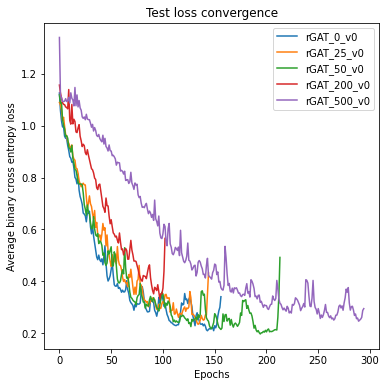

In [18]:
losses = stats[0]

fig, ax = plt.subplots(1,1,figsize=(6,6))

for key in ["rGAT_0_v0","rGAT_25_v0","rGAT_50_v0", "rGAT_200_v0", "rGAT_500_v0"]:
    ax.plot(np.array(losses[key])[:,2], label=key)

ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Average binary cross entropy loss")
ax.set_title("Test loss convergence")
plt.show()


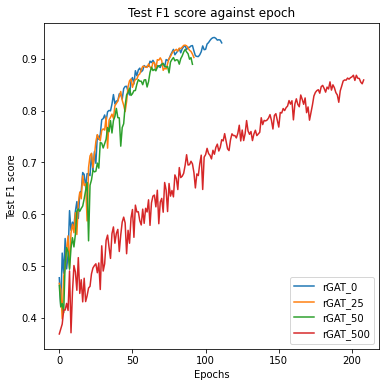

In [159]:
F1 = stats[2]

fig, ax = plt.subplots(1,1,figsize=(6,6))

for key in ["rGAT_0","rGAT_25","rGAT_50", "rGAT_500"]:
    ax.plot(np.array(F1[key]), label=key)

ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Test F1 score")
ax.set_title("Test F1 score against epoch")
plt.show()


In [15]:
def plot_attention(data, model, central_node = 1, figsize=(20,5), labels=False):
    model.to(device)
    data.to(device)
    
    x = model.rni.forward(data.x)
    out, attention = model.conv1.forward(x, data.edge_index, return_attention_weights=True)
    edge_indices, attention_cfs = attention
    
    fig, ax = plt.subplots(1,4, figsize=figsize)
    
    for head in range(4):
        
        edges = list(zip(edge_indices[0].cpu().numpy(), edge_indices[1].cpu().numpy(),attention_cfs.detach().cpu().numpy()[:,head] ))

        # Full graph
        # G = nx.Graph()
        # G.add_weighted_edges_from(edges)

        filtered_edges = list(filter(lambda x : x[1] == central_node,  edges)) # get edges with destination node
        filtered_nodes = list(map(lambda x : x[0], filtered_edges))

        # Graph with just nodes and edges  involving central_node
        H = nx.Graph()
        H.add_weighted_edges_from(filtered_edges)

        # Specify circular positioning for nodes
        pos = nx.circular_layout(filtered_nodes, scale=2)
        pos[central_node] = np.array([0, 0])



        # Draw the graph with weighted edges
        nx.draw_networkx_nodes(H, pos, node_size=70, ax=ax[head])
        if labels:
            nx.draw_networkx_labels(H, pos, ax=ax[head])

        edge_labels = nx.get_edge_attributes(H, "weight")
        edge_label_array = np.array(list(edge_labels.values()))
        edge_label_array = edge_label_array**0.5
        nx.draw_networkx_edges(H, pos, width=4, edge_color=edge_label_array, edge_cmap = plt.cm.Blues, ax=ax[head])
    
    plt.show()
    
    

In [16]:
import matplotlib


datalist = []

for d in train_loader:
    datalist.append(d)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

 4


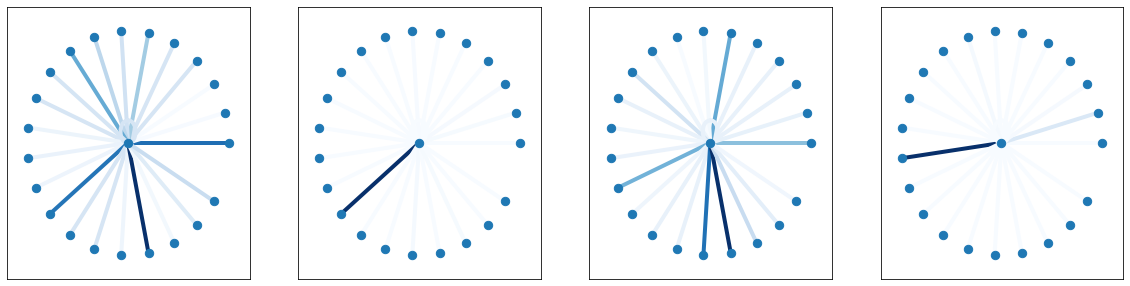

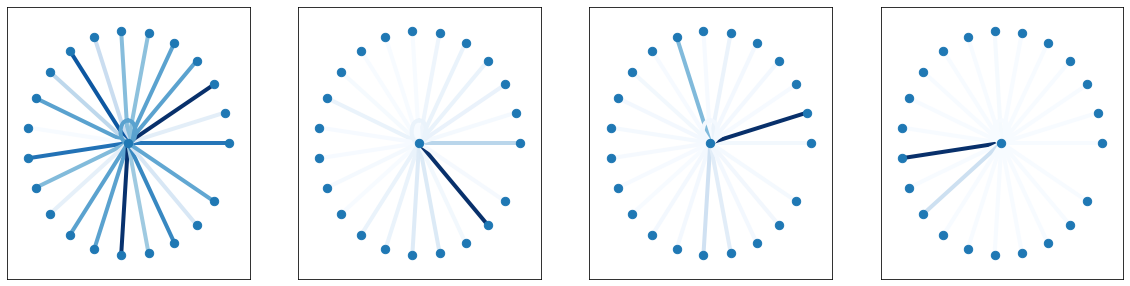

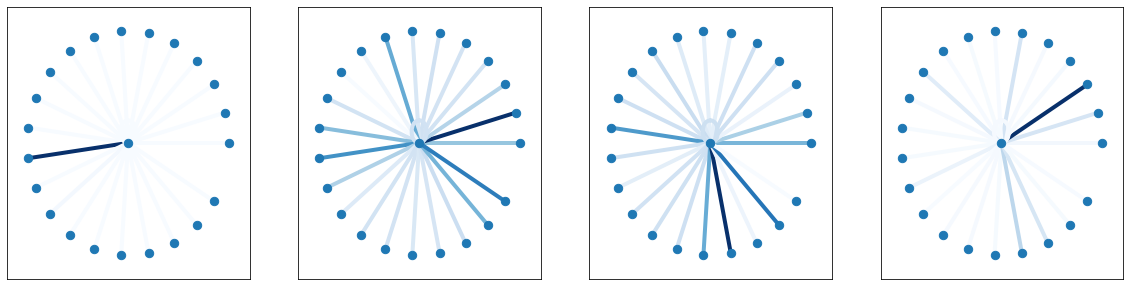

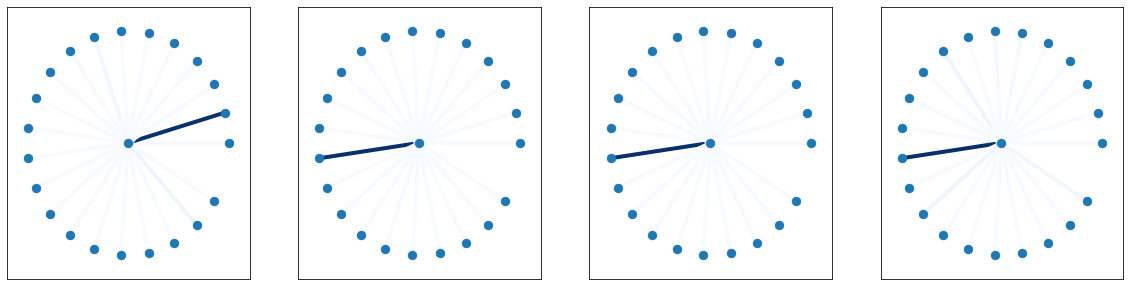

In [51]:

node_occurences = list(data.edge_index.cpu().numpy().flatten())
print(np.unique(node_occurences, return_counts=True))

central_node = int(input())

data = datalist[0]

model0 = rGAT(0).to(device)
model0.load_state_dict(torch.load(f"best_models/rGAT_0"))

plot_attention(data, model0,central_node)

model0 = rGAT(5).to(device)
model0.load_state_dict(torch.load(f"best_models/rGAT_5"))

plot_attention(data, model0,central_node)

model0 = rGAT(50).to(device)
model0.load_state_dict(torch.load(f"best_models/rGAT_50"))

plot_attention(data, model0,central_node)
               
model1 = rGAT(500).to(device)
model1.load_state_dict(torch.load(f"best_models/rGAT_500"))

plot_attention(data, model1,central_node)


In [11]:

def norm_entropy(weights):
    weights += 0.0000000001
    return -sum(np.log2(weights) * weights) / np.log2(len(weights))

def calculate_total_entropy(model, loader):
    count = 0
    ne_total = 0
    for data in loader:
        data.to(device)
        x = model.rni.forward(data.x)
        out, attention = model.conv1.forward(x, data.edge_index, return_attention_weights=True)
        edge_indices, attention_cfs = attention

        ne_sum = 0

        for head in range(4):
            edges = list(zip(edge_indices[0].cpu().numpy(), edge_indices[1].cpu().numpy(),attention_cfs.detach().cpu().numpy()[:,head] ))
            for node in range(data.num_nodes):

                filtered = list(filter(lambda x : x[1] == node,  edges)) # get edges with destination node
                weights = np.array([x[2] for x in filtered])

                if len(weights) > 0 :
                    ne = norm_entropy(weights)
                    if not (np.isnan(ne)):
                        count += 1
                        ne_sum += ne


        ne_total += ne_sum
     
    ne_total = ne_total / count
    return ne_total



In [12]:
entropies = {}

In [13]:
for version in range(4,5):
    for num in [200, 500]:#[0, 5, 25, 50, 100,200, 500]:
        print(num)
        key = f"{num}_{version}"
        model = rGAT(num).to(device)
        model.load_state_dict(torch.load(f"best_models/rGAT_{num}_v{version}"))

        entropies[key] = calculate_total_entropy(model, test_loader)
        print(entropies[key])
        print("\n")
    

200


/tmp/ipykernel_32/913427045.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return -sum(np.log2(weights) * weights) / np.log2(len(weights))


0.44043435230734357


500
0.1459629928120118




In [ ]:
"""Entropy output:
0
0.46237131550618393


5
0.6863124879620401


25
0.5970200526605551


50
0.6096065044802004


100
0.5821495499592031


200
0.47180915903929516


500
0.2847760363364252


0
0.5158378032503481


5
0.741975469038686


25
0.5403585038472659


50
0.607320964140167


100
0.3637698462936695


200
0.34848096520673527


500
0.12135739409156861


0
0.5730672303447806


5
0.6746790691745909


25
0.7809738220568189


50
0.559387901165857


100
0.4815296710212807


200
0.4089850080155402


500
0.20670289324629915


0
0.6595455343564768


5
0.7217697556666238


25
0.56165303867968


50
0.576705989515875


100
0.5052194359062517


200
0.45097234260417585


500
0.1558218563054208


0
0.5683209011915001


5
0.6614813295294287


25
0.5585653821993128


50
0.5699911070935989


100
0.4542676622255186

200
0.44043435230734357

500
0.1459629928120118
"""

In [ ]:
"""
0.9875 or so optimal F1 score
0.9 without linear (could go up further, stopped at 100 epochs)
0.92 with 50 random features - stopped at 100
no meaningful learning without linear and with 500 random features


GCN performance: about 70%
GAT: about 90% without linear features
"""